Author:  Raphael Cousin

Project: https://github.com/racousin/algorithms_basics_python

# Theory

__Context:__

* Data : $X \in \mathbb{R}^d$ 

* Classes : $Y \in \{-1,1\}$

* Classifier :
$g^*(x) = \left\{\begin{array}{ll}1 & if\quad\mathbb{P}(Y = 1 | X = x) >\mathbb{P}(Y = -1 | X = x) \\-1 & else\end{array}\right.$

* sample size: $n$

* feature size: $p$

__Hypothesis:__

$\mathbb{E}(X|Y=1) = \mu_+$

$\mathbb{E}(X|Y=-1) = \mu_-$

$var(X|Y=1) = \Sigma_+$

$var(X|Y=-1) = \Sigma_-$

$\mathbb{E}(X) = \mu$


__Rayleigh Quotient:__

$\forall w \in \mathbb{R}^p$

Variance of Average of Projections : $vm(w) = var\left[\mathbb{E}(w^TX|Y))\right]$ 


Average of Variance of Projections : $mv(w) = \mathbb{E}\left[var(w^TX|Y)\right]$ 

$r(w) = \frac{vm(w)}{mv(w)}$

$\forall w \in \mathbb{R}^p$

$r(w) = \frac{w^TMw}{w^T\Sigma w}$

$Argmax_{w \in \mathbb{R}^p} r(w)= \left\{\lambda \in \mathbb{R}^p, \lambda \Sigma^{-1}(\mu_+ - \mu_-)\right\}$

with:

Intra class dispersion average : $\Sigma = \pi_+ \Sigma_+ + \pi_- \Sigma_-$

Inter class dispersion avergage : $M = \pi_+(\mu_+ - \mu)(\mu_+ - \mu)^T + \pi_-(\mu_- - \mu)(\mu_- - \mu)^T$

__Results:__

$g^*(x) = \left\{\begin{array}{ll}1 & if \quad w_0^Tx+b_0>0\\-1 & else\end{array}\right.$

with:

$w_0 \in Argmax_{w \in \mathbb{R}^p} r(w)$

$b_0 \in Argmin_{b \in \mathbb{R}}\left\{\mathbb{P} \left(Y \neq sign(w_0^TX + b_0)\right)\right\}$ 

__Empirical estimators:__

$\hat{\pi_i} = \frac{1}{n}\#[Y = i]$

$\hat{\mu_i} = \frac{1}{\#[Y = i]}\sum_{Y_j=i}X_j$

$\hat{\mu} = \frac{1}{n}\sum_{j=1}^nX_j$

$\hat{\Sigma_i} = \frac{1}{\#[Y = i]}\sum_{Y_j=i}(X_j-\hat{\mu_i})(X_j-\hat{\mu_i})^T$ 

# Algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.discriminant_analysis import LinearClassifierMixin

In [2]:
class FDA(BaseEstimator, LinearClassifierMixin):
    """
        Fisher discriminant analysis for two classes.
    """
    def __init__(self):
        self.coef = None
        self.intercept = None
    
    def fit(self, X, y):
        X1 = X[y==1]
        X2 = X[y==-1]
        cov1 = np.cov(X1.T, bias=True)
        cov2 = np.cov(X2.T, bias=True)
        mu1 = X1.mean(axis=0)
        mu2 = X2.mean(axis=0)
        pi1, pi2 = len(X1), len(X2)
        X1, X2 = None, None
        cov = pi1*cov1 + pi2*cov2
        invcov = np.linalg.inv(cov)
        self.coef = invcov.dot(mu1-mu2)
        
        ypred = X.dot(self.coef)
        ind = np.argsort(ypred)
        err = np.cumsum(y[ind]) + np.sum(y==-1)
        iintercept = np.argmin(err)
        if iintercept < y.size-1:
            self.intercept = 0.5*(ypred[ind[iintercept]] + ypred[ind[iintercept+1]])
        else:
            self.intercept = ypred[ind[iintercept]]
        return self

    def decision_function(self, X):
        return X.dot(self.coef) + self.intercept

    def predict(self, X):
        return np.sign(self.decision_function(X))

# Example

In [3]:
#2d plot function
def plot_2dX_Y(X, Y, ax=plt):
    X1 = X[Y == 1]
    X2 = X[Y == -1]
    ax.plot(X1[:, 0], X1[:, 1], ">", label="Class 1")
    ax.plot(X2[:, 0], X2[:, 1], "d", label="Class 2")

In [4]:
# plot border from clf
def plot_border(clf, data=None, num=500, label=None,ax=plt):
    """
        Plot the frontiere f(x)=0 of the classifier clf within the same range as the one
        of the data.
        Input:
            clf: binary classifier with a method decision_function
            data: input data (X)
            num: discretization parameter
    """
    xmin, ymin = data.min(axis=0)
    xmax, ymax = data.max(axis=0)
    x, y = np.meshgrid(np.linspace(xmin, xmax, num), np.linspace(ymin, ymax))
    z = np.fabs(clf.decision_function(np.c_[x.ravel(), y.ravel()])).reshape(x.shape)
    zmin, zmax = z.min(), z.max()
    ind = np.where((z-zmin)/(zmax-zmin) < 0.001)
    ind_sort = np.argsort(y[ind])
    ax.plot(x[ind][ind_sort], y[ind][ind_sort], label=label, linewidth=2)

In [5]:
def get_metrics(clf,X,Y):
    """
        Input:
            clf: binary classifier with a method predict_function
            data: (X)
            classes: (Y) consider that Y=1 is 'yes class' and Y=-1 is 'No class'
    """
    pred = clf.predict(X)
    TP = ((pred == 1) & (Y == 1)).sum()
    TN = ((pred == -1) & (Y == -1)).sum()
    FP = ((pred == 1) & (Y == -1)).sum()
    FN = ((pred == -1) & (Y == 1)).sum()
    accuracy = (TP + TN) / (TP + TN + FN + FP)
    prec = TP/ (TP + FP)
    recall = TP / (TP + FN)
    F1Score = 2*(recall * prec) / (recall + prec)
    print('True Positive:',TP)
    print('True Negative:',TN)
    print('False Positive:',FP)
    print('False Negative:',FN)
    print('Accuracy:', accuracy)
    print('Precision:', prec)
    print('Recall:', recall)
    print('F1 Score:', F1Score)

In [6]:
#generate data
p = 2;
n = 1000;
mu1 = np.random.randn(p) * 3
mu2 = np.random.randn(p) * 3
A = np.random.rand(p,p)
sigma1 = np.dot(A,A.transpose()) * 10
A = np.random.rand(p,p)
sigma2 = np.dot(A,A.transpose()) * 10

n1 = np.random.randint(int(n*0.1),int(n*0.9));
n2 = n - n1;
X1 = np.random.multivariate_normal(size=n1,mean=mu1,cov=sigma1)
X2 = np.random.multivariate_normal(size=n2,mean=mu2,cov=sigma2)

Y1 = np.ones(n1)
Y2 = -np.ones(n2)
X = np.r_[X1, X2]
Y = np.r_[np.ones(X1.shape[0]), -np.ones(X2.shape[0])]

In [7]:
#train set and test set
data = np.c_[X,Y]
np.random.shuffle(data)
X_train = data[:int(n *0.9),0:p]
Y_train = data[:int(n *0.9),p]
X_test = data[int(n *0.9):,0:p]
Y_test = data[int(n *0.9):,p]

In [8]:
#compute model
fda = FDA()
fda.fit(X_train, Y_train)

FDA()

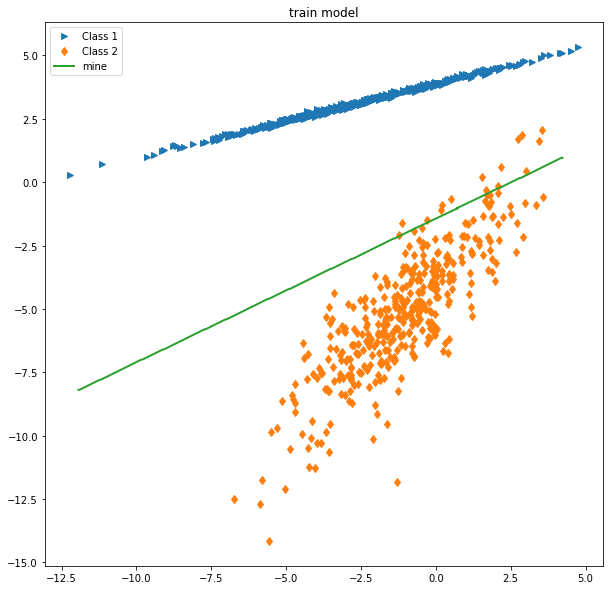

In [9]:
#plot train
fig, ax = plt.subplots(figsize=(10,10))
plot_2dX_Y(X_train, Y_train,ax)
plot_border(fda, X_train,ax = ax,label='mine')
ax.set_title('train model')
ax.legend(loc="best");

In [10]:
#metrics train
get_metrics(fda, X_train, Y_train)

True Positive: 513
True Negative: 372
False Positive: 15
False Negative: 0
Accuracy: 0.9833333333333333
Precision: 0.9715909090909091
Recall: 1.0
F1 Score: 0.9855907780979827


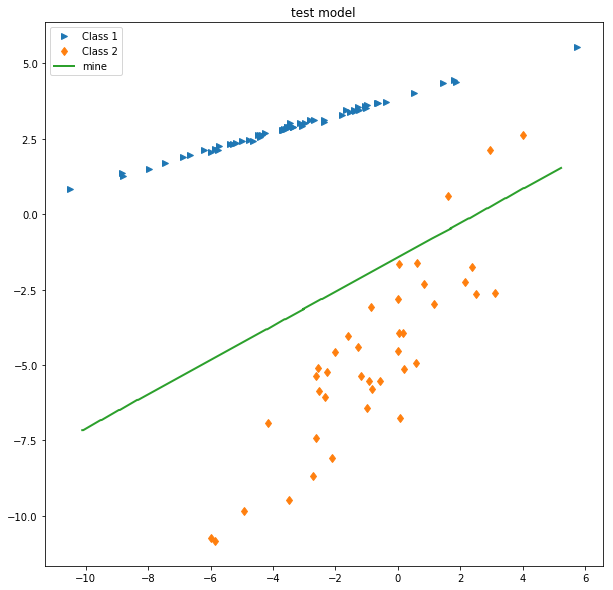

In [11]:
#plot test
fig, ax = plt.subplots(figsize=(10,10))
plot_2dX_Y(X_test, Y_test,ax)
plot_border(fda, X_test,ax = ax,label='mine')
ax.set_title('test model')
ax.legend(loc="best");

In [12]:
#metrics test
get_metrics(fda, X_test, Y_test)

True Positive: 60
True Negative: 37
False Positive: 3
False Negative: 0
Accuracy: 0.97
Precision: 0.9523809523809523
Recall: 1.0
F1 Score: 0.975609756097561


# References